In [49]:
from numpy import *
from scipy.integrate import quad, dblquad
from scipy.special import j0, j1
import matplotlib.pyplot as plt
from time import time, perf_counter_ns

In [37]:
# setup the field

# the output field for a plane wave of wave number k and
# amplitude A0 passing through
# 1) circular aperture, radius a
# 2) lens f1
# 3) circular aperture radius b
# 4) lens f2

# field returned at radius=r2

TODO: 
1) make field input aperture periodic, 1D  
2) plot axial field from lens f2 onward using eq i derived

In [239]:
## functions

def from_quadrant3(qd3, field=None):
    """
    construct field with rectangular symmetry given only
    quadrant 3 (i.e., field is mirrored across x axis and
    across y axis)
    
    'qd3' 2D numpy array
    Return 'field' 2D numpy array
    """
    
    xpts, ypts = qd3.shape
    xmpt, ympt = int(xpts/2), int(ypts/2)
    
    if field is None:
        field = zeros((2*xpts, 2*ypts))
    
    field[:midpt, :midpt] = qd3
    # qd4
    field[:midpt, midpt:] = flip(qd3, axis=1) 
    # qd1
    field[midpt:, midpt:] = flip(qd3)
    # qd2
    field[midpt:, :midpt] = flip(qd3, axis=0)
    
    return field

def get_meshgrid(w, pts, radial=False):
    midpt = int(pts/2)
    x = linspace(-w, w, pts)
    y = linspace(-w, w, pts)
    xx, yy = meshgrid(x,y, sparse=True)
    if radial:
        rr = sqrt(xx**2 + yy**2)
        return x,midpt,rr
    else:
        return x,midpt,xx,yy

In [344]:
## physics and system params
k = 2*pi/1.064e-6
A0 = 1
# want M = f2/f1 something like ~ .03
f1 = 1
f2 = 0.03
a = 1e-4 # aperture 1 radius = 100 um
b = f1*3.8317/(a*k) # aperture 2 radius; 3.8317 is the Fourier filtered beam

In [345]:
## build meshgrid 
w = 100*a # array width 
pts = 1000
    
x,midpt,rr = get_meshgrid(w, pts, radial=True)    

In [346]:
## calculate the field in Fourier plane
A1 = lambda r1: -1j*A0*a*j1(a*r1*k/f1)/r1
qd3 = zeros((midpt, midpt), complex)
for i in range(midpt):
    for j in range(midpt):
        qd3[i,j] = A1(rr[i,j])
field1 = from_quadrant3(abs(qd3))

Text(0, 0.5, 'y/a')

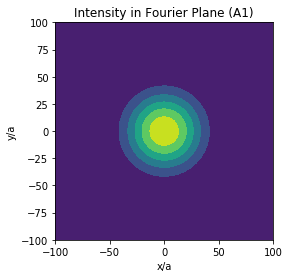

In [347]:
fig,ax = plt.subplots()
I1 = conjugate(field1)*field1
ax.contourf(x/a,x/a,I1)
ax.set_title('Intensity in Fourier Plane (A1)')
ax.set_aspect('equal')
ax.set_xlabel('x/a')
ax.set_ylabel('y/a')

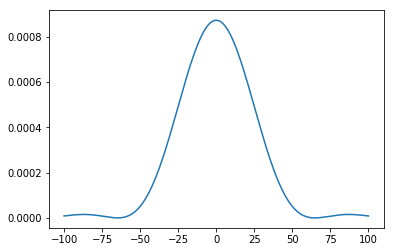

In [348]:
fig, ax= plt.subplots()
ax.plot(x/a, I1[midpt,:])

In [349]:
b

0.006488633711537092

In [333]:
## how much of the field is in that central ring?

# i must be missing something to be getting such a small integral
# result
# I1int = lambda r1: r1*(a*A0*j1(a*r1*k/f1)/r1)**2

# total = 2*pi*quad(I1int, 0, inf)[0]
# print(f'total field {total}') # should be 1
# central = 2*pi*quad(I1int, 0, .2)[0]
# print(f'central field {central}')

total field 4.871927066824569e-08
central field 2.9508606600003133e-08


In [356]:
## calcute the output field in the back focal plane of lens f2

w = 1e-5
pts = 200
x,midpt,rr = get_meshgrid(w, pts, radial=True)    

def integrand(r1, r2, a, k, f1, f2):
    """output field for 4f Fourier filtered plane wave"""
    return j1(a*r1*k/f1)*j0(r1*r2*k/f2)

# calculate only one quadrant, then reflect
field = zeros((pts, pts))
qd3 = field[0:midpt, 0:midpt]

t0 = time()
for i in range(midpt):
    for j in range(midpt):
        args = (rr[i,j], a, k, f1, f2)
        qd3[i,j] = quad(integrand, 0, b, args)[0]
print(f'run time: {time()-t0} [s]')
field = from_quadrant3(qd3, field=field)
# field *= -k*A0*a/f2 #

run time: 0.7151234149932861 [s]


Text(0, 0.5, 'y [um]')

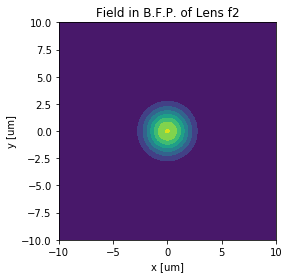

In [360]:
# question: how to get phase of field here? could calculate phase
# using the transfer function on the input field?

fig, ax = plt.subplots()
ax.contourf(x*1e6,x*1e6,field**2)
ax.set_aspect('equal')
ax.set_title('Field in B.F.P. of Lens f2')
ax.set_xlabel('x [um]')
ax.set_ylabel('y [um]')

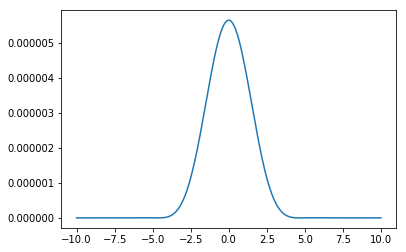

In [362]:
plt.plot(x*1e6,field[midpt,:]**2)